# Get depth data for pose detections

## Setup

In [78]:
import sys
sys.path.append("../")

In [79]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cv2
from common import plot_helpers
from skimage.segmentation import chan_vese
import pathlib
import json
import scipy
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits import mplot3d
from tqdm import tqdm
from common.realsense_params import MIN_VALID_DEPTH_METERS
from common.realsense_params import MAX_VALID_DEPTH_METERS

np.set_printoptions(suppress=True)
%matplotlib inline 
# %matplotlib notebook

In [80]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [81]:
MIN_VALID_DEPTH_MM = MIN_VALID_DEPTH_METERS*1000
MAX_VALID_DEPTH_MM = MAX_VALID_DEPTH_METERS*1000


In [82]:
colormap = mcolors.LinearSegmentedColormap.from_list(
    "", plt.cm.viridis.colors, N=0xFFFF)

In [83]:
subj='QKZF-SWAL-UJPN'

cam='lower'
algorithm='openpose:25B'
activity='simon-says'
color_idx=1300

# cam='upper'
# algorithm='mp-hands'
# activity='target-touch'
# hand='left'
# color_idx=22

data = h5py.File(f'/home/mjsobrep/Downloads/data/{subj}/{activity}/full_data-vid.hdf5', 'r')
pose_data=h5py.File(f'/home/mjsobrep/Downloads/data/{subj}/{activity}/full_data-novid.hdf5', 'r')
depth_idx=data[f'vid/{cam}/color/matched_depth_index'][color_idx]
color_img=data[f'vid/{cam}/color/data'][color_idx]
depth_img=data[f'vid/{cam}/depth/data'][depth_idx]

if algorithm=='mp-hands':
    poses=pose_data[f'vid/{cam}/pose/{algorithm}/{hand}/keypoints-median5/color'][color_idx][:,:2]
else:
    poses=pose_data[f'vid/{cam}/pose/{algorithm}/keypoints-median5/color'][color_idx]

In [84]:
data[f'vid/{cam}/depth/data'][0].shape

(720, 1280)

In [85]:
depth_img[depth_img < MIN_VALID_DEPTH_MM] = 0
depth_img[depth_img > MAX_VALID_DEPTH_MM] = 0

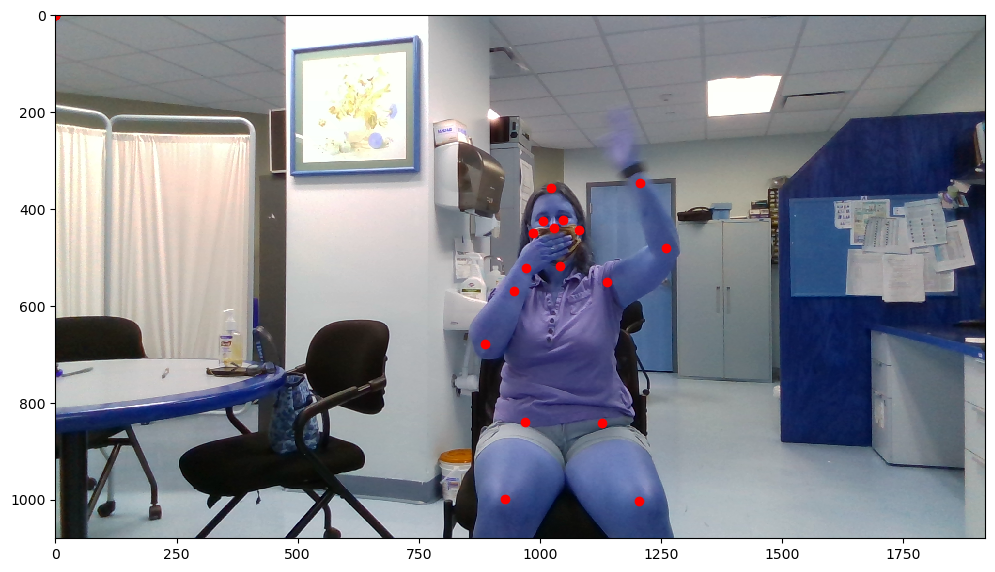

In [86]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(color_img)
plt.plot(poses[:,0], poses[:,1],'or')

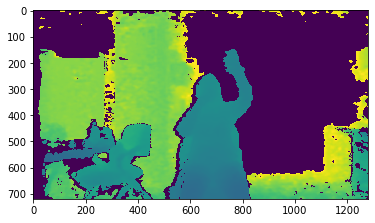

In [87]:
plt.imshow(depth_img)

## Intrinsics and Extrinsics

In [88]:
directory = pathlib.Path('/home/mjsobrep/Downloads/data/')
with open(directory/'transforms.json', encoding='utf-8') as json_file:
    transforms = json.load(json_file)

trans = (np.array([trans['translation']
                   for trans in transforms['robot'][cam].values()]))
rot = (np.array([trans['rotation']
                 for trans in transforms['robot'][cam].values()]))

# TODO: construct H matrix and use cv2 built in cv2.warpPerspective
r_cd = np.asarray(rot[0]).reshape(3, 3) 
t_cd = np.asarray(trans[0]).reshape(3, 1) * 1000 # convert from meters to millimeters 
k_c = data[f'vid/{cam}/color/data'].attrs['K'].reshape(3, 3)
inv_kc = np.linalg.inv(k_c)
k_d = data[f'vid/{cam}/depth/data'].attrs['K'].reshape(3, 3)

In [89]:
print(f'Kc:\n{k_c}')
print(f'Kd:\n{k_d}')
print(f'R:\n{r_cd}')
print(f'T:\n{t_cd}')

Kc:
[[1380.21655273    0.          950.19494629]
 [   0.         1378.97607422  533.08294678]
 [   0.            0.            1.        ]]
Kd:
[[900.53271484   0.         629.89440918]
 [  0.         900.53271484 366.64901733]
 [  0.           0.           1.        ]]
R:
[[ 0.99999177  0.00293971 -0.00278787]
 [-0.00294319  0.99999487 -0.00124542]
 [ 0.00278419  0.00125362  0.99999535]]
T:
[[15.18026181]
 [-0.06847952]
 [-0.40547943]]


## Depth to color

Here we map the depth to the color images by passing through the indeces from the depth space to the color space.
The indeces are first made homogenous, then de-projected from the depth imager to world coordinates, using
the inverse of the depth K matrix. 

In [90]:
# %%timeit 99.8 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

# Grid of index values | row 0: x, row 1: y 
indices=np.reshape(np.indices(np.flip(depth_img.shape)), (2,-1))
# Made homogenous by adding 1 to bottom | row 0: x, row 1: y, row 2: 1
indices_h = np.concatenate((indices, np.ones((1,indices.shape[1]))))

# Construct the homogenous tranformation between color and depth
HT = np.eye(4)
HT[:3, :3] = r_cd.T
HT[:3, 3] =  (t_cd).flatten() # TODO: is this complete
# # Make the inverse of that
HT_inv = HT.copy()
HT_inv[:3, :3] = np.linalg.inv(HT[:3, :3])
HT_inv[:3, 3] = -HT_inv[:3, :3]@HT[:3, 3]

# Transform to world using inverse of depth imager K matrix and remove scale ambiguity by multiply by z
# z is stored in milimeters, but everything else is meters
world_d = (np.linalg.inv(k_d)@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))

# Make world coordinate homogenous
world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
# Bring world coordinates from depth camera space to rgb camera space
world_c_h = HT@world_d_h
# Divide out depth to move back to pixel coordinates (should this come before/after the next step)
# world_c = world_c_h[:3,:]/world_c_h[2,:]
# Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
px_color = (k_c@world_c_h[:3,:])
valid_px_color = px_color[2,:] != 0
px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
depth_color = world_c_h[2,valid_px_color]
color_pixels = px_color_norm[:2,:].T

Check HT

In [91]:
print(f'HT:\n{HT}')

HT:
[[ 0.99999177 -0.00294319  0.00278419 15.18026181]
 [ 0.00293971  0.99999487  0.00125362 -0.06847952]
 [-0.00278787 -0.00124542  0.99999535 -0.40547943]
 [ 0.          0.          0.          1.        ]]


These transformations are pretty small. I doubt the rotations are quite accurate. 

### Test transformation from depth pixels to depth world and back

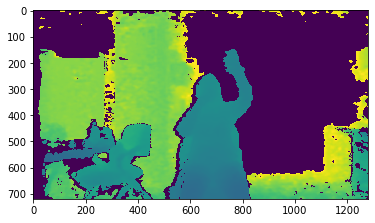

In [92]:
# project 3d points back into depth to make sure we did that right
im=np.zeros(depth_img.shape)
a=k_d@world_d
valid=a[2,:]!=0
a=a[:,valid]
dp=world_d[2,valid]
a=np.round(a/a[2,:]).astype('uint16')
im[a[1,:], a[0,:]]=world_d[2,valid]

plt.imshow(im)

### Test transformation to color camera pixel space

In [93]:
# %%timeit # 66.7 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

def create_depth_projected(color_img_shape, color_pixels, world_c_h):
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    x_low=np.atleast_2d(np.floor(color_pixels[:,0])).astype('uint16')
    x_high=np.atleast_2d(np.ceil(color_pixels[:,0])).astype('uint16')
    y_low=np.atleast_2d(np.floor(color_pixels[:,1])).astype('uint16')
    y_high=np.atleast_2d(np.ceil(color_pixels[:,1])).astype('uint16')

    for points in (np.concatenate((x_low.T,y_low.T),axis=1),
                  np.concatenate((x_low.T,y_high.T),axis=1),
                  np.concatenate((x_high.T,y_low.T),axis=1),
                  np.concatenate((x_high.T,y_high.T),axis=1)):
        # points=np.ceil(c).astype('uint16')
        valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
        im[points[valid,1], points[valid,0]] = world_c_h[2, valid]
    return(im)

# im = create_depth_projected(color_img.shape, color_pixels, world_c_h)

In [94]:
# %lprun -f create_depth_projected create_depth_projected(color_img.shape, color_pixels, world_c_h)

In [95]:
def create_depth_projected2(world_d, r_cd, t_cd, k_c, color_img_shape):
    color_pixels,_ = cv2.projectPoints(world_d.T,r_cd.T,t_cd,k_c,None)
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    color_pixels=np.round(color_pixels).astype('uint16')
    valid=np.all(color_pixels>=0, axis=2).flatten()
    valid=np.all((valid,(color_pixels[:,0,0]<color_img_shape[1])),axis=0)
    valid=np.all((valid, (color_pixels[:,0,1]<color_img_shape[0])),axis=0)
    im[color_pixels[valid,0,1], color_pixels[valid,0,0]]= world_d[2,valid]
    im=scipy.ndimage.maximum_filter(im,3)
    return(im)
# im=create_depth_projected2(world_d, r_cd, t_cd, k_c, color_img.shape)

In [96]:
# %lprun -f create_depth_projected2 create_depth_projected2(world_d, r_cd, t_cd, k_c, color_img.shape)

In [97]:
# %%timeit # 66.7 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

def create_depth_projected3(color_img_shape, color_pixels, world_c_h):
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    points=np.round(color_pixels[:,:2]).astype('uint16')
    valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
    im[points[valid,1], points[valid,0]] = world_c_h[2, valid]
    im=scipy.ndimage.maximum_filter(im,3) # take out in production
    return(im)


im = create_depth_projected3(color_img.shape, color_pixels, world_c_h)

In [98]:
# %lprun -f create_depth_projected3 create_depth_projected3(color_img.shape, color_pixels, world_c_h)

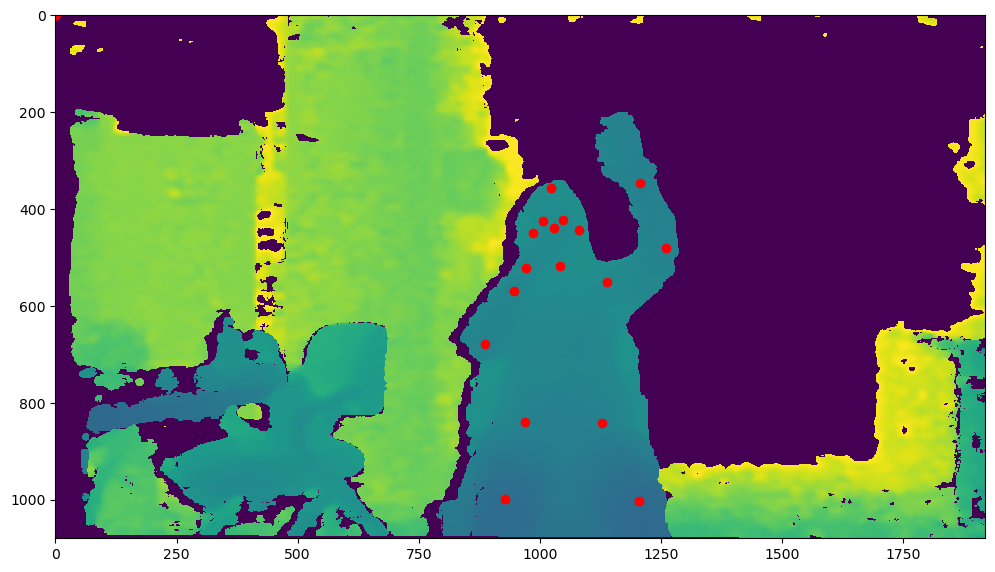

In [99]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(im)
plt.plot(poses[:,0], poses[:,1],'or')

Get poses in 3D

In [100]:
int_poses=np.round(poses).astype('uint16')
depths=im[int_poses[:,1],int_poses[:,0]]
poses_3d_c = (inv_kc@np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T)*depths
print(f'Keypoint positions in milimeters:\n{poses_3d_c.T}')

Keypoint positions in milimeters:
[[ 109.71488398 -131.45235297 1906.50494109]
 [ 138.02645226 -157.14967057 1951.46604968]
 [  80.41253091 -153.98052029 1951.6177686 ]
 [ 189.97542593 -130.95363527 1993.27928305]
 [  52.14156142 -120.43584713 1983.6602372 ]
 [ 262.80132669   25.427761   1926.89149843]
 [  -5.82442985   48.10442676 1821.59682081]
 [ 399.14311967  -66.83502154 1773.61815026]
 [ -82.24037214  188.62568502 1790.64270306]
 [ 326.45153033 -239.69731046 1758.03949759]
 [  27.55646883  -15.07257693 1862.58765547]
 [ 228.34428684  393.44937265 1759.52237014]
 [  23.47942447  393.43832808 1772.09384601]
 [ 259.02713839  478.99972667 1407.3246461 ]
 [ -23.42815312  482.37356427 1431.10387125]
 [  -0.           -0.            0.        ]
 [  -0.           -0.            0.        ]
 [ 129.45993296  -22.39658298 1968.31775817]
 [ 104.14091834 -253.54297628 1978.67998602]
 [  -0.           -0.            0.        ]
 [  -0.           -0.            0.        ]
 [  -0.           -0.

In [101]:
np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T

array([[1029.62316895, 1047.81713867, 1007.06402588, 1081.74060059,
         986.47467041, 1138.43737793,  945.78179932, 1260.80517578,
         886.80456543, 1206.48828125,  970.61486816, 1129.31433105,
         968.48217773, 1204.23266602,  927.59985352,    0.        ,
           0.        , 1040.97436523, 1022.83782959,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [ 438.00338745,  422.03533936,  424.28323364,  442.48754883,
         449.35986328,  551.28027344,  569.49871826,  481.11917114,
         678.34381104,  345.06848145,  521.92388916,  841.43780518,
         839.24169922, 1002.43389893,  997.8861084 ,    0.        ,
           0.        ,  517.39221191,  356.38449097,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ],
       [   1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,


Overlay depth and color to check alignment

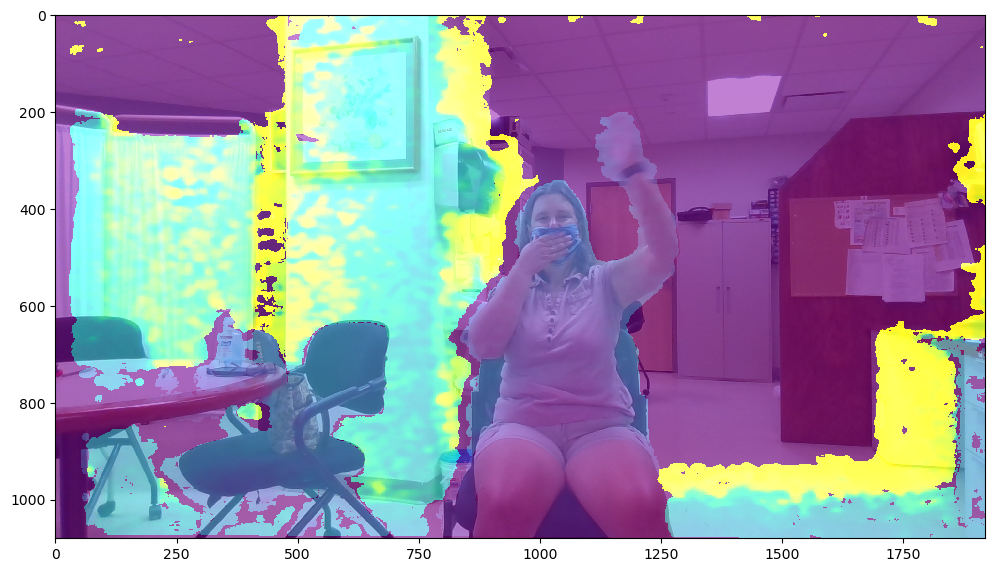

In [102]:
depth_img_s = plot_helpers.stretch_histogram(im.astype('uint16'))
depth_img_s = (colormap(depth_img_s) * 0xFFFF).astype(np.uint16)[:, :, :3]
# convert from 16 to 8 bit
depth_img_s = cv2.convertScaleAbs(depth_img_s, alpha=(0xFF/0xFFFF))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.addWeighted(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB), .5, depth_img_s, 1,0))

### Bring Back to depth coordinates

In [103]:
color_pixels

array([[-50722.09040764,    765.97173937],
       [-50722.09040764,    765.97173937],
       [-50722.09040764,    765.97173937],
       ...,
       [-50722.09040764,    765.97173937],
       [-50722.09040764,    765.97173937],
       [-50722.09040764,    765.97173937]])

In [104]:
# %%timeit # 274 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
def get_pose_depth(color_pixels, poses, depth_img, k_d):
    # KD Tree to find the nearest depth point to each keypoint in the color image
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', n_jobs=-1).fit(color_pixels)
    _, id = nbrs.kneighbors(poses)
    # Find the x and y positions in depth space for the corresponding keypoints
    row = id%depth_img.shape[0]
    col = (id-row)/depth_img.shape[0]
    poses_h=np.concatenate((col,row, np.ones((len(row),1))),axis=1).T
    poses_d = depth_img[np.round(row).astype('uint16'),np.round(col).astype('uint16')]
    poses_d = (np.linalg.inv(k_d)@poses_h)*(poses_d.T)
    return(poses_d, col, row)
poses_d, col, row=get_pose_depth(color_pixels, poses, depth_img, k_d)

In [105]:
# %lprun -f get_pose_depth get_pose_depth(color_pixels, poses, depth_img, k_d)

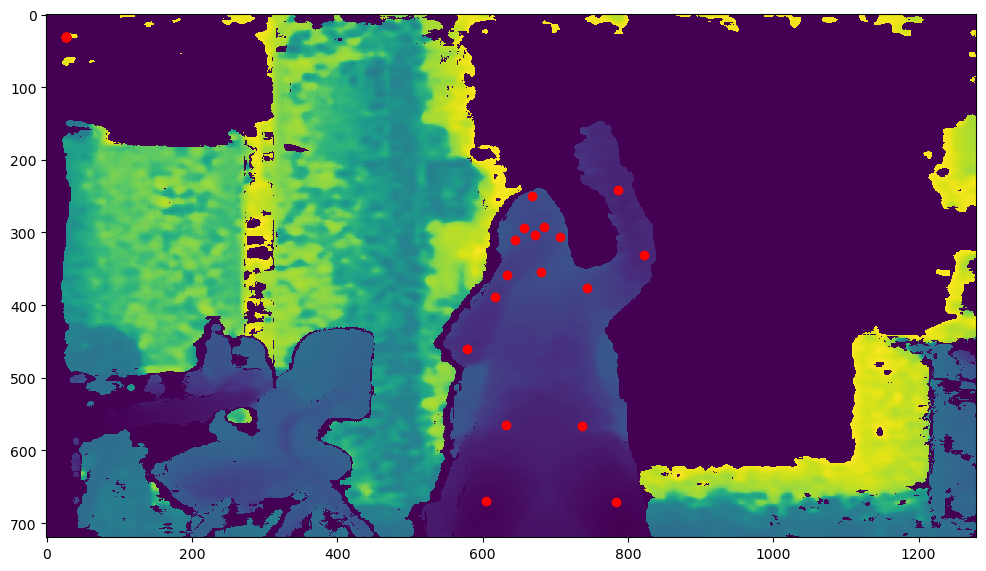

In [106]:
depth_img_s = plot_helpers.stretch_histogram(depth_img)
depth_img_s = (colormap(depth_img_s) * 0xFFFF).astype(np.uint16)[:, :, :3]
# convert from 16 to 8 bit
depth_img_s = cv2.convertScaleAbs(depth_img_s, alpha=(0xFF/0xFFFF))

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(depth_img_s)
plt.plot(col, row,'or')

## Try to go quick
### Work in depth coordinates

In [107]:
k_c_padded = np.concatenate((k_c,np.zeros((3,1))),axis=1)
C_color = k_c_padded@HT
k_d_inv=np.linalg.inv(k_d)

In [108]:
# %%timeit # 220 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

world_d = (k_d_inv@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))

# Make world coordinate homogenous
world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
# Bring world coordinates from depth camera space to rgb camera space
# Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
px_color = (C_color@world_d_h)
valid_px_color = px_color[2,:] != 0
px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
# depth_color = world_c_h[2,valid_px_color]
color_pixels1 = px_color_norm[:2,:].T

depth_locs=[np.where(np.all((color_pixels1[:,0]<pose[0]+1, 
                 color_pixels1[:,0]>pose[0]-1,
                 color_pixels1[:,1]<pose[1]+1, 
                 color_pixels1[:,1]>pose[1]-1),axis=0))[0] for pose in poses]
depth_locs_mind = np.array([depth_loc[np.argmin(depth_img.flatten(order='F')[depth_loc])] if len(depth_loc) else 0 for depth_loc in depth_locs])
row = depth_locs_mind%depth_img.shape[0]
col = (depth_locs_mind-row)/depth_img.shape[0]
poses_in_depth=np.concatenate((np.atleast_2d(col),np.atleast_2d(row)),axis=0).T
poses_3d=world_d[:,depth_locs_mind].T

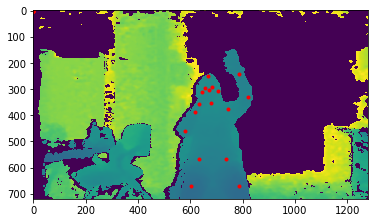

In [109]:
plt.imshow(depth_img)
plt.plot(poses_in_depth[:,0],poses_in_depth[:,1],'r.')

In [110]:
# %%timeit # 370 ms ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
color_pixels2,_ = cv2.projectPoints(world_d.T,r_cd.T,t_cd,k_c,None)
# np.max(color_pixels1 - np.squeeze(color_pixels2)) = 1.4551915228366852e-11

### Work in color coordinates

In [111]:
window = 1 # what area of depth to look over +/-. Will take closest depth in this pixel window (1=3x3, 2=5x5)
indices=np.reshape(np.indices(np.flip(depth_img.shape)), (2,-1))
# Made homogenous by adding 1 to bottom | row 0: x, row 1: y, row 2: 1
indices_h = np.concatenate((indices, np.ones((1,indices.shape[1]))))
HT = np.eye(4)
HT[:3, :3] = r_cd.T
HT[:3, 3] =  (t_cd).flatten()
k_c_padded = np.concatenate((k_c,np.zeros((3,1))),axis=1)
color_cam_matrix = k_c_padded@HT
k_d_inv=np.linalg.inv(k_d)
k_c_inv = np.linalg.inv(k_c)
HT_inv = HT.copy()
HT_inv[:3, :3] = np.linalg.inv(HT[:3, :3])
HT_inv[:3, 3] = -HT_inv[:3, :3]@HT[:3, 3]
def create_depth_projected3(color_img_shape, color_pixels, world_c_h):
    im=np.zeros((color_img_shape[0], color_img_shape[1]))
    points=np.round(color_pixels[:,:2]).astype('uint16')
    valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
    im[points[valid,1], points[valid,0]] = world_c_h[2, valid]
    return(im)

In [112]:
# %%timeit # 111 ms ± 722 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
def extract_depth(depth_img, indices_h,k_d, k_d_inv, k_c_inv, HT_inv, color_cam_matrix,color_img_shape ):
    world_d = (k_d_inv@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))
    # Make world coordinate homogenous
    world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
    # Bring world coordinates from depth camera space to rgb camera space
    # Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
    px_color = (color_cam_matrix@world_d_h)
    valid_px_color = px_color[2,:] != 0
    px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
    # depth_color = world_c_h[2,valid_px_color]
    color_pixels4 = px_color_norm[:2,:].T

    im = create_depth_projected3(color_img_shape, color_pixels4, px_color)
    int_poses=np.round(poses).astype('uint16')
    depths=[np.max(im[max(pose[1]-window,0):min(pose[1]+window,im.shape[0]),max(pose[0]-window,0):min(pose[0]+window,im.shape[1])]) for pose in int_poses]
    poses_3d_c = (k_c_inv@np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T)*depths
    poses_d_from_c=(HT_inv@np.concatenate((poses_3d_c, np.ones((1,poses_3d_c.shape[1]))),axis=0))[:3,:]
    poses_in_depth = k_d@poses_d_from_c
    poses_in_depth = (poses_in_depth/poses_in_depth[2,:])[:2,:].T
    valid_poses = np.all((poses_in_depth[:,0]>0, 
                          poses_in_depth[:,0]<depth_img.shape[1], 
                          poses_in_depth[:,1]>0, 
                          poses_in_depth[:,1]<depth_img.shape[0]), 
                         axis=0)
    poses_in_depth[~valid_poses]=0
    poses_3d_c[:,~valid_poses]=0
    return(poses_3d_c, poses_in_depth)

posed_3d_c, poses_in_depth=extract_depth(depth_img, indices_h,k_d, k_d_inv, k_c_inv, HT_inv, color_cam_matrix,color_img.shape )

In [113]:
# %lprun -f extract_depth extract_depth(depth_img, indices_h,k_d, k_d_inv, k_c_inv, HT_inv, color_cam_matrix,color_img.shape )

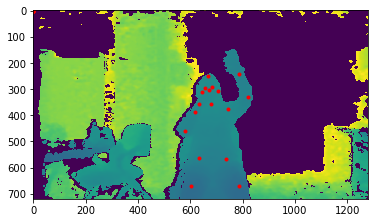

In [114]:
plt.imshow(depth_img)
plt.plot(poses_in_depth[:,0],poses_in_depth[:,1],'r.')

### Check Poses from all directions

In [115]:

print(f'Keypoint positions in milimeters:\n{poses_d.T}')

Keypoint positions in milimeters:
[[   89.16429173  -134.7854154   1907.        ]
 [  117.27959633  -159.64204239  1952.        ]
 [   58.75423781  -157.47443652  1952.        ]
 [  168.09386005  -133.9550396   1989.        ]
 [   30.95128806  -122.10823265  1976.        ]
 [  242.15397787    22.16098788  1928.        ]
 [  -26.05993577    45.17191634  1820.        ]
 [  378.65078979   -70.26619325  1775.        ]
 [ -101.21996163   187.64738601  1791.        ]
 [  304.9192214   -243.475465    1759.        ]
 [    6.40752707   -17.84485332  1858.        ]
 [  209.44596718   389.83267869  1761.        ]
 [    4.13620749   389.63924636  1769.        ]
 [  241.11814472   476.19650848  1409.        ]
 [  -41.17650956   480.78942613  1432.        ]
 [-2672.58972581 -1487.90916211  3992.        ]
 [-2672.58972581 -1487.90916211  3992.        ]
 [  109.55505191   -25.4703852   1969.        ]
 [   83.61345037  -255.9578952   1976.        ]
 [-2672.58972581 -1487.90916211  3992.        ]
 [-267

In [116]:
# compare to from other side:
poses_d_from_c=(HT_inv@np.concatenate((poses_3d_c, np.ones((1,poses_3d_c.shape[1]))),axis=0))[:3,:]
print(f'Keypoint positions in milimeters in depth frame, calculated from color:\n{poses_d_from_c.T}')

Keypoint positions in milimeters in depth frame, calculated from color:
[[  88.83139899 -134.03634984 1907.00000484]
 [ 116.94184704 -159.8728587  1952.00751356]
 [  59.33729088 -156.53434468 1952.0027963 ]
 [ 168.8508342  -133.88192765 1993.99802738]
 [  31.07583427 -122.94654174 1984.00845547]
 [ 242.32093513   22.36701335 1928.00935719]
 [ -25.94241099   45.96531733 1821.99569321]
 [ 378.81769198  -70.10568959 1775.0006652 ]
 [-101.85833967  186.74931845 1791.00512334]
 [ 305.66196409 -242.73375176 1759.00299443]
 [   7.13821513  -17.36066229 1863.00007532]
 [ 209.41265777  390.69661184 1761.00643484]
 [   4.51439287  391.27286709 1773.00745443]
 [ 241.32863282  476.59486047 1409.00303157]
 [ -41.18072102  480.77038578 1431.99996455]
 [ -15.18106661    0.11265259    0.36329857]
 [ -15.18106661    0.11265259    0.36329857]
 [ 108.72455255  -25.11623127 1969.0042214 ]
 [  82.69735328 -256.19983527 1979.00613834]
 [ -15.18106661    0.11265259    0.36329857]
 [ -15.18106661    0.1126525

In [117]:
print(f'Keypoint positions in milimeters in depth frame, calculated in direct path:\n{poses_3d}')

Keypoint positions in milimeters in depth frame, calculated in direct path:
[[  89.0707791  -132.52864227 1905.        ]
 [ 117.27959633 -159.64204239 1952.        ]
 [  58.75423781 -157.47443652 1952.        ]
 [ 168.09386005 -133.9550396  1989.        ]
 [  30.95128806 -122.10823265 1976.        ]
 [ 242.15397787   22.16098788 1928.        ]
 [ -26.05993577   45.17191634 1820.        ]
 [ 378.65078979  -70.26619325 1775.        ]
 [-101.21996163  185.6585632  1791.        ]
 [ 306.17467566 -240.97295061 1755.        ]
 [   6.40752707  -17.84485332 1858.        ]
 [ 209.20809555  391.34322685 1759.        ]
 [   4.13153117  391.16089906 1767.        ]
 [ 241.11814472  476.19650848 1409.        ]
 [ -41.17650956  480.78942613 1432.        ]
 [  -0.           -0.            0.        ]
 [  -0.           -0.            0.        ]
 [ 107.36856833  -25.4703852  1969.        ]
 [  81.41919361 -255.9578952  1976.        ]
 [  -0.           -0.            0.        ]
 [  -0.           -0.   

## Check Implementation

In [118]:
from pose.src import extract_depth